In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from image_segmentation_info import *

In [2]:
def get_mission_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '\\mission_' + str(mission_number) + '_'

In [3]:
def get_mission_segmentation_file_path(mission_number):
    return '..\\missions\\mission_' + str(mission_number) + '_segmentation\\mission_' + str(mission_number) + '_'

In [4]:
def plot_images(image_list, title_list=[], grid='off'):
    fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
    if len(image_list) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
        if len(title_list) > 0:
            ax.set_title(title_list[i])
        ax.axis(grid)

In [5]:
def load_mission_image(mission_number):
    mission_image = cv2.imread(get_mission_segmentation_file_path(mission_number) + 'bordered.png')
    h, w, c = mission_image.shape
    mission_image = mission_image[BORDER_H:h-2*BORDER_H, BORDER_W:w-2*BORDER_W, :]
    mission_image = cv2.resize(mission_image, (0,0), fx=0.1, fy=0.1)
    mission_image = mission_image[CROP:h-CROP, CROP:w-CROP, :]
        
    print('mission_image.shape:', mission_image.shape)
    
    cv2.imwrite(get_mission_file_path(mission_number) + 'global_image.png', mission_image)

    return mission_image

In [6]:
def load_regions_mask(mission_number):
    regions_mask = dict()
    for name in REGION_NAMES:
        region_mask = np.load(get_mission_segmentation_file_path(mission_number) + 'region_mask_' + name + '.npy').astype(np.uint8)*255
        h, w = region_mask.shape

        region_mask = region_mask[BORDER_H:h-2*BORDER_H, BORDER_W:w-2*BORDER_W]
        region_mask = cv2.resize(region_mask, (0,0), fx=0.1, fy=0.1)
        region_mask = region_mask[CROP:h-CROP, CROP:w-CROP]

        print(name, ':', region_mask.shape)
        
        regions_mask[name] = region_mask
        
    return regions_mask

In [7]:
def load_samples_mask(mission_number):
    samples_mask = dict()
    for name in REGION_NAMES:
        sample_mask = np.load(get_mission_segmentation_file_path(mission_number) + 'sample_mask_' + name + '.npy').astype(np.uint8)*255
        h, w = sample_mask.shape

        sample_mask = sample_mask[BORDER_H:h-2*BORDER_H, BORDER_W:w-2*BORDER_W]
        sample_mask = cv2.resize(sample_mask, (0,0), fx=0.1, fy=0.1)
        sample_mask = sample_mask[CROP:h-CROP, CROP:w-CROP]

        print(name, ':', sample_mask.shape)
        
        samples_mask[name] = sample_mask
        
    return samples_mask

In [8]:
def calculate_masked_images(mission_image, masks):
    images = dict()
    for name in REGION_NAMES:
        image = cv2.bitwise_and(mission_image, mission_image, mask=masks[name])
        images[name] = image.astype(np.uint8)

    return images

In [9]:
def save_regions_image(mission_number, regions_image):
    for name in REGION_NAMES:
        np.save(get_mission_file_path(mission_number) + 'region_image_%s.npy' % (name), regions_image[name])

In [10]:
def save_samples_image(mission_number, samples_image):
    for name in REGION_NAMES:
        np.save(get_mission_file_path(mission_number) + 'sample_image_%s.npy' % (name), samples_image[name])

In [11]:
# def compute_alignment_transfer(reference_landmarks, new_landmarks):
    
    
    
    
    
#     return {vertical_shift, horizontal_shift}

In [115]:
# def compute_similarity(region_ideal, region_image):
    

# Start

In [12]:
mission_number = 2

mission_image = load_mission_image(mission_number)
regions_mask = load_regions_mask(mission_number)
samples_mask = load_samples_mask(mission_number)

mission_image.shape: (647, 653, 3)
GRASS : (647, 653)
SIDEWALK : (647, 653)
BUILDING : (647, 653)
GRAVEL : (647, 653)
GRASS : (647, 653)
SIDEWALK : (647, 653)
BUILDING : (647, 653)
GRAVEL : (647, 653)


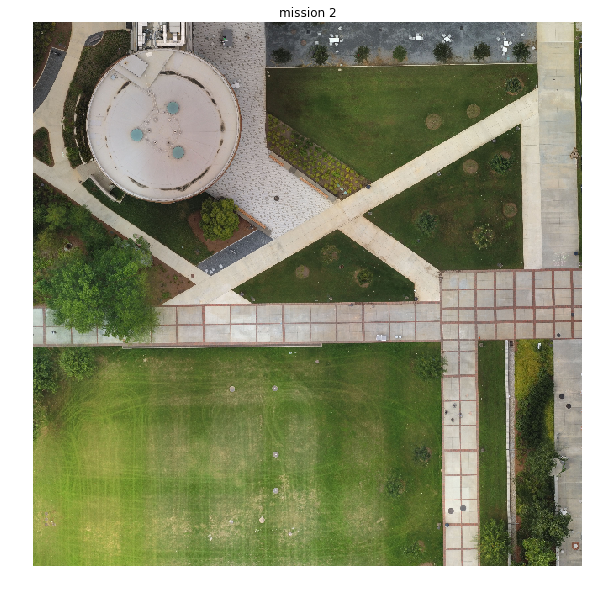

In [13]:
plot_images([mission_image], ['mission ' + str(mission_number)])

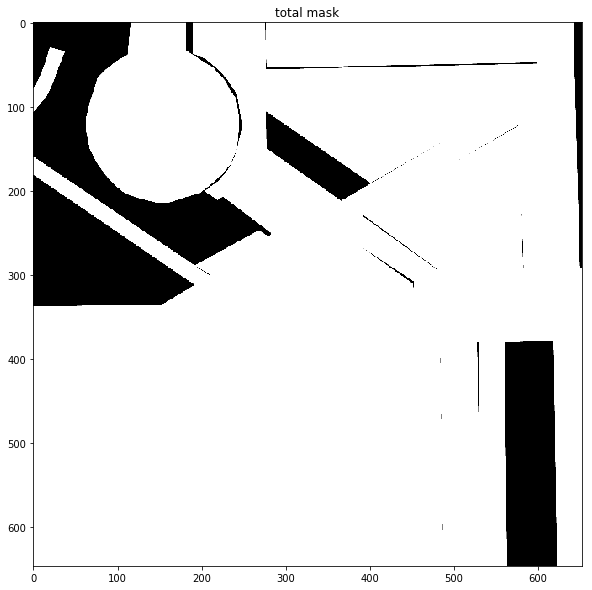

In [14]:
plot_images([cv2.bitwise_or(cv2.bitwise_or(regions_mask[REGION_NAMES[0]], regions_mask[REGION_NAMES[1]]), cv2.bitwise_or(regions_mask[REGION_NAMES[2]], regions_mask[REGION_NAMES[3]]))], ['total mask'], grid='on')

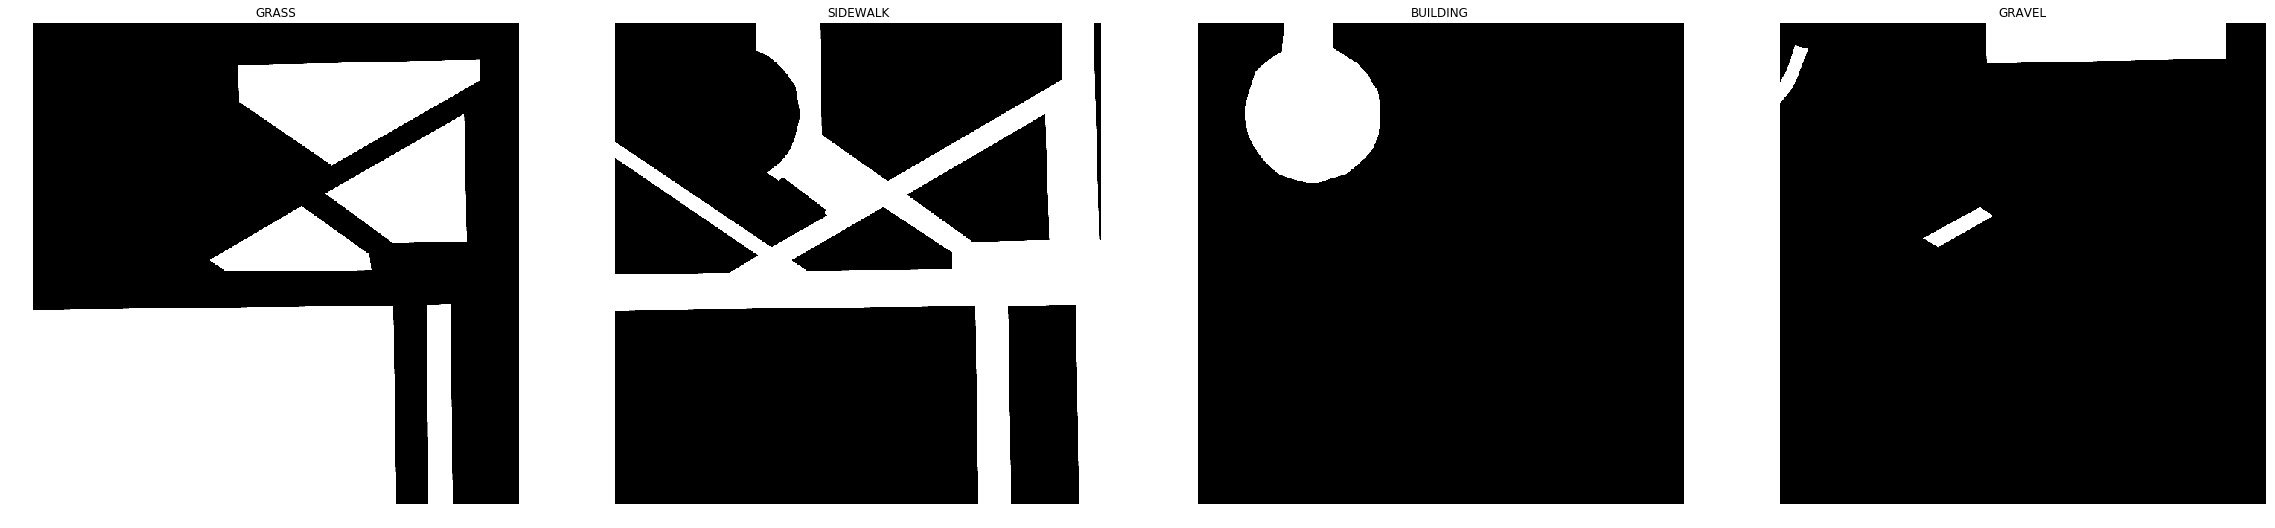

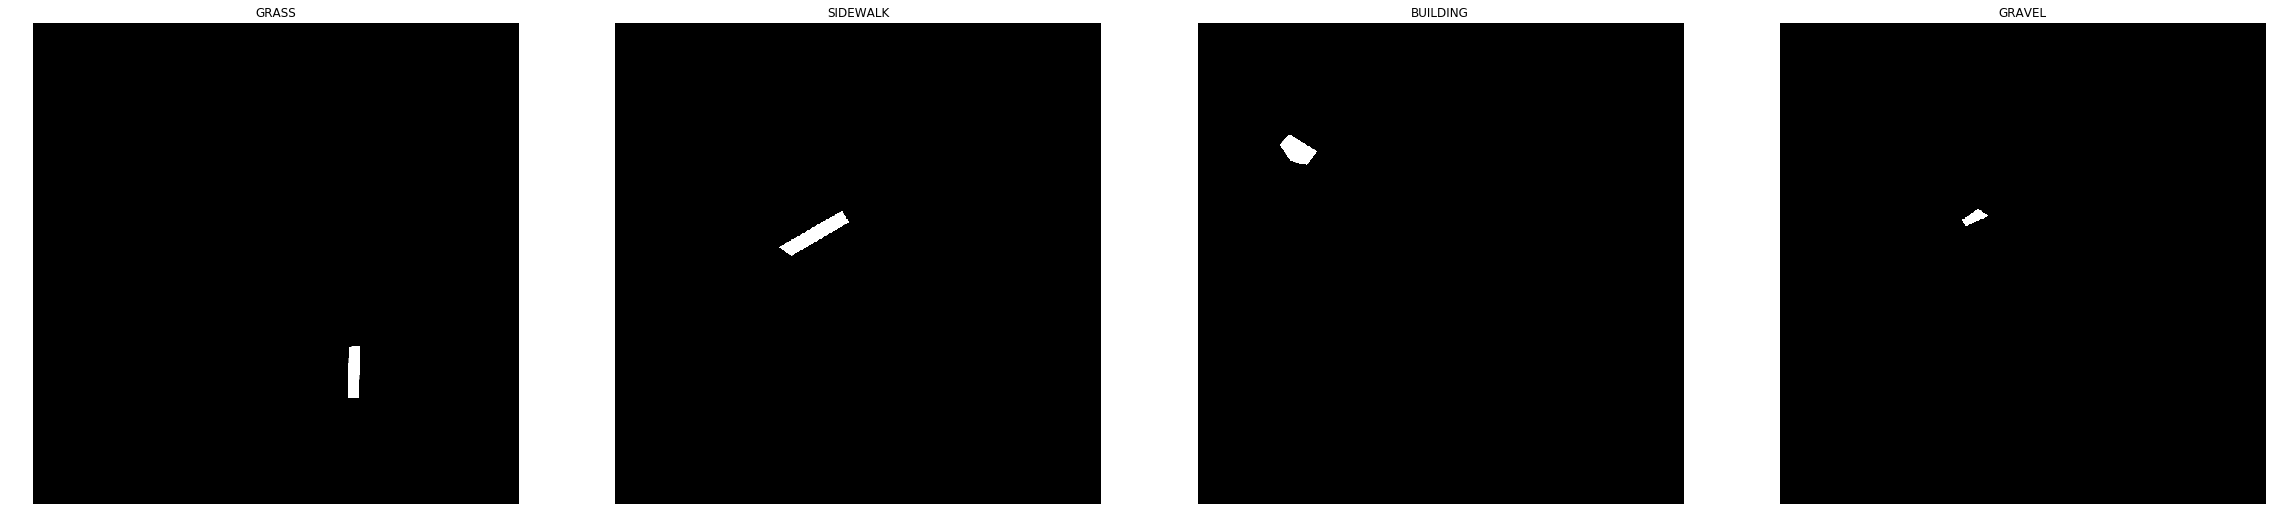

In [15]:
plot_images(list(regions_mask.values()), REGION_NAMES)
plot_images(list(samples_mask.values()), REGION_NAMES)

In [16]:
regions_image = calculate_masked_images(mission_image, regions_mask)
samples_image = calculate_masked_images(mission_image, samples_mask)

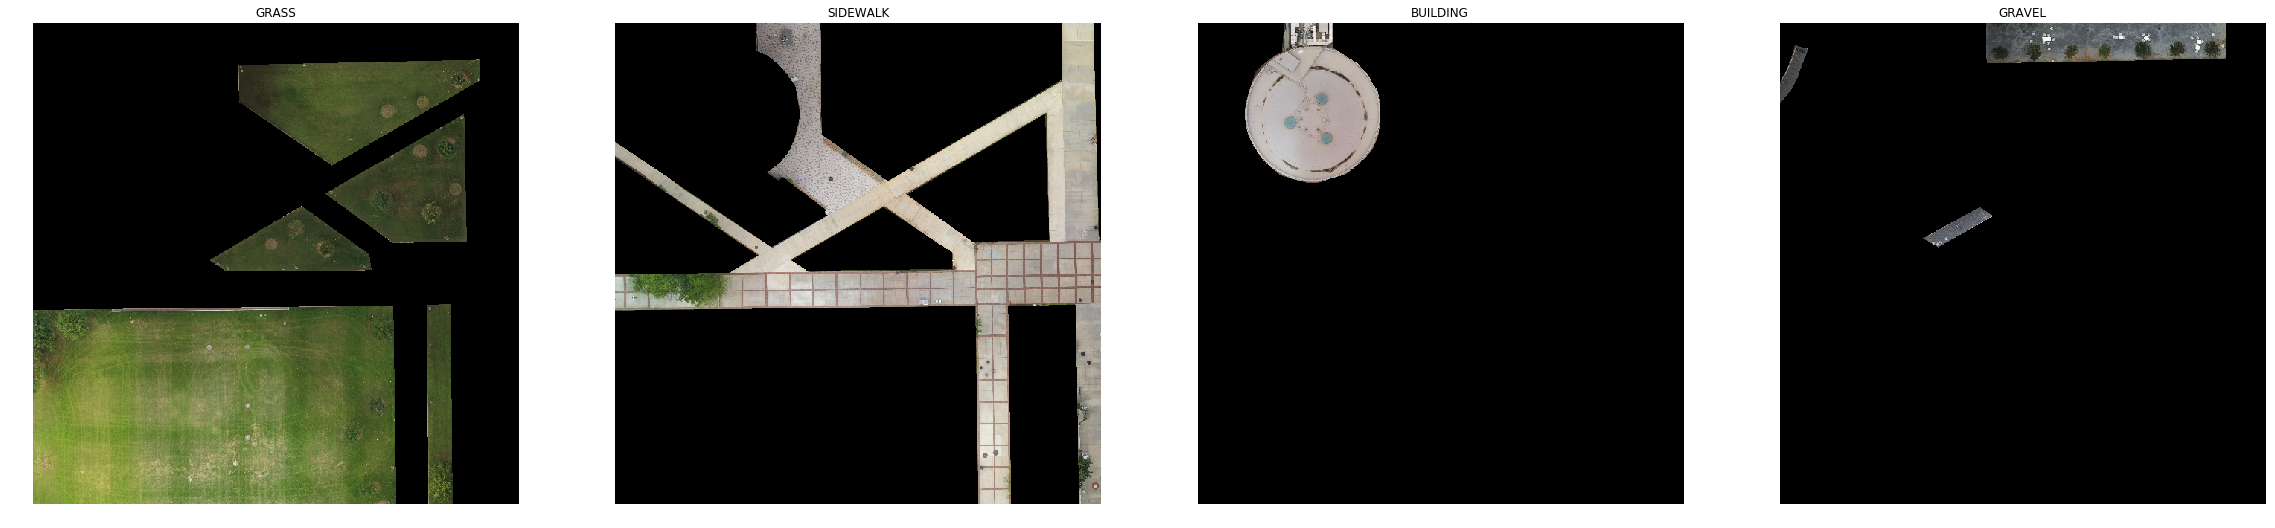

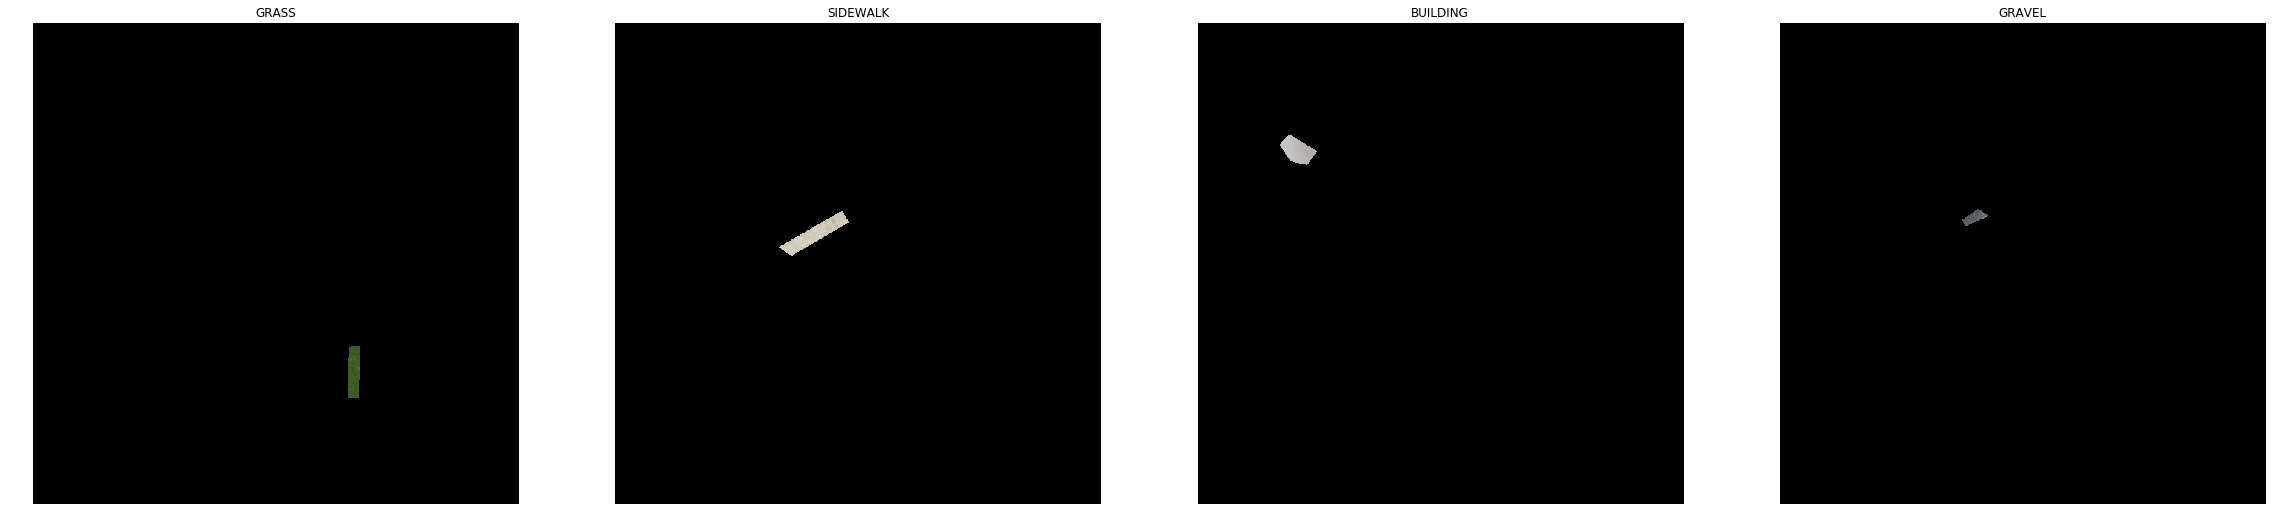

In [17]:
plot_images(list(regions_image.values()), REGION_NAMES)
plot_images(list(samples_image.values()), REGION_NAMES)

In [18]:
save_regions_image(mission_number, regions_image)
save_samples_image(mission_number, samples_image)